In [1]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
#from tensorflow.keras.utils import to_categorical ## specific  one I wanna use
from tensorflow.keras import utils
#from tensorflow.keras.layers import Input, Dense, Dropout  # Specific ones I wanna use, can just import whole module
from tensorflow.keras import layers 
from tensorflow.keras.models import Model
import h5py
#import tables
import matplotlib.pyplot as plt
#import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight


from sklearn.model_selection import GridSearchCV
#from keras.wrappers.scikit_learn import KerasClassifier

from tensorflow.keras.optimizers import Adam

In [2]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV


#from keras.wrappers.scikit_learn import KerasClassifier
#from tensorflow.keras import utils
#from tensorflow.keras.models import Model


import h5py

In [3]:
import tensorflow as tf
gpu_available = tf.test.is_gpu_available()
gpu_available

True

In [4]:
x=1
y=3
x+y



4

In [5]:
# Load the HDF5 file
with h5py.File('DF_event_based.h5', 'r') as hf:
    # Access the dataset by name and load it into a pandas dataframe
    df_total = pd.DataFrame(hf['dataset_name'][:])

with h5py.File('4_event_types_weights.h5', 'r') as f:
    df_weights = f['array'][:]

with h5py.File('rnn_run8_predictions.h5', 'r') as f:
    predicted_val = f['val_preds'][:]
    predicted_train = f['train_preds'][:]

with h5py.File('4_event_types_labels.h5', 'r') as f:
    df_labels = f['array'][:]

In [6]:
# df column headers
column_names = ['dataset', 'DiJet_mass', 'HT', 'InputMet_InputJet_mindPhi',
       'InputMet_pt', 'MHT_pt', 'MinChi', 'MinOmegaHat', 'MinOmegaTilde',  'ncleanedBJet',
       'ncleanedJet']


# use rename() to rename columns
df_total = df_total.rename(columns=dict(zip(df_total.columns, column_names)))


In [7]:
df_Xvars = df_total.drop(['dataset'], axis = 1, inplace = False)   #Need to remove dataset (prediction) column

x = df_Xvars.values
y = df_labels

X_train, X_valid, y_train, y_valid = train_test_split(x, y, train_size=0.8, test_size=0.2,
                                                      random_state=72)


In [8]:
X_train = np.hstack((X_train, predicted_train))
X_valid = np.hstack((X_valid, predicted_val))
input_shape = [X_train.shape[1]] 

input_shape = [X_train.shape[1]]
print('There are', input_shape, 'variables in this model')
print('The dataset has', len(y), 'processes')
print(input_shape)

There are [11] variables in this model
The dataset has 881096 processes
[11]


In [9]:
#Define the Model

#2 hidden
model = keras.Sequential([
    layers.BatchNormalization(input_shape=([11])), 
    layers.Dense(units=256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate = 0.2), 
    layers.Dense(units=256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate = 0.2),
    layers.Dense(units=1, activation='sigmoid'),
])


from tensorflow.keras.optimizers import Adam

lr = 0.0001 # specify learning rate
optimizer = Adam(learning_rate=lr)
#model.compile(optimizer=optimizer, loss='categorical_crossentropy')



model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)


model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 11)                44        
_________________________________________________________________
dense (Dense)                (None, 256)               3072      
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

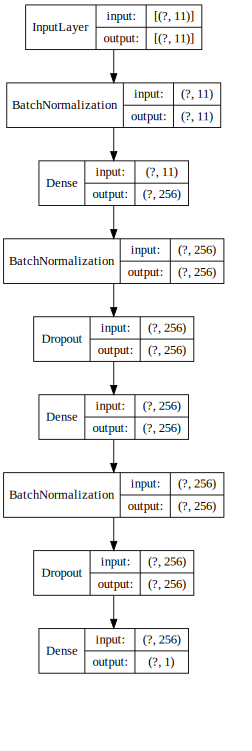

In [10]:
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, dpi=65).create(prog='dot', format='svg'))


Train on 704876 samples, validate on 176220 samples
Epoch 1/15
704876/704876 [==============================] - 18s 26us/sample - loss: 0.5969 - binary_accuracy: 0.6962 - val_loss: 0.5579 - val_binary_accuracy: 0.7245
Epoch 2/15
704876/704876 [==============================] - 16s 22us/sample - loss: 0.5659 - binary_accuracy: 0.7151 - val_loss: 0.5553 - val_binary_accuracy: 0.7313
Epoch 3/15
704876/704876 [==============================] - 15s 22us/sample - loss: 0.5571 - binary_accuracy: 0.7220 - val_loss: 0.5543 - val_binary_accuracy: 0.7282
Epoch 4/15
704876/704876 [==============================] - 15s 21us/sample - loss: 0.5529 - binary_accuracy: 0.7245 - val_loss: 0.5539 - val_binary_accuracy: 0.7307
Epoch 5/15
704876/704876 [==============================] - 15s 21us/sample - loss: 0.5510 - binary_accuracy: 0.7273 - val_loss: 0.5532 - val_binary_accuracy: 0.7308
Epoch 6/15
704876/704876 [==============================] - 14s 21us/sample - loss: 0.5490 - binary_accuracy: 0.7292 -

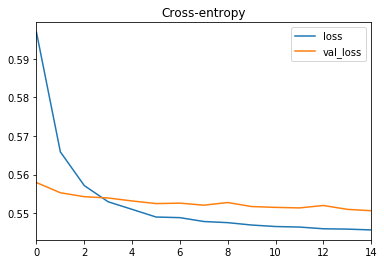

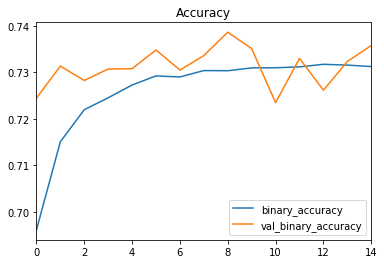

In [11]:
# Train the model, on the full data set

early_stopping = keras.callbacks.EarlyStopping(
    patience=150,
    min_delta=0.001,
    restore_best_weights=True,
)

class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
class_weight = {0: class_weights[0], 
               1: class_weights[1]}        # Done by compute_class_weight('balanced', np.unique(y_train), y_train) in cell above

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=256,
    epochs=15,
    callbacks=[early_stopping],
    #verbose = 0   #Hide output of epochs
    class_weight = class_weight
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")
history_df = pd.DataFrame(history.history)

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))
# 73.5%
#takes like 10 mins to run rn, only 3 layers

In [9]:
#model.save('trained_combined_model_run8.h5')

from tensorflow.keras.models import load_model
model = load_model('trained_combined_model_run8.h5')


In [10]:
# #using a permutation method to see what features are important


features = ['DiJet_mass', 'HT', 'InputMet_InputJet_mindPhi',
            'InputMet_pt', 'MHT_pt', 'MinChi', 'MinOmegaHat', 'MinOmegaTilde',  'ncleanedBJet',
            'ncleanedJet', 'RNN prediction']

y_pred = model.predict(X_train)    # can do train or valid, want to see if results differ

# Get the number of features
n_features = X_train.shape[1]

# Initialize an array to store feature importances
importances = np.zeros(n_features)

# Calculate the feature importances using the permutation feature importance method
# Drops each variable one at a time 
for i in range(n_features):
    print(i)    #counter to check is working, should go to 40
    feature_name = features[i]
    X_permuted = X_train
    X_permuted[:, i] = np.random.permutation(X_permuted[:, i])
    y_permuted = model.predict(X_permuted)
    importances[i] = np.abs(y_permuted - y_pred).mean()
    #importances[i] = (y_permuted - y_pred).mean()    #try without a abs, see if positively or negatively affected by removal?
    print(f"Permuted feature {feature_name}")

# Normalize the feature importances
importances /= importances.sum()   # importances sum to 1, so can be taken as a literal how important a variable
# is for the model

print(importances)  # using abs

print()#

print(np.sort(importances))

# np.random.permutation randomly permutes (rearranges in a random order) the elements.
# In this case, it is used to shuffle the values in a single column of the X_permuted array.
# Guess then this variable isnt useful in the prediction

0
Permuted feature DiJet_mass
1
Permuted feature HT
2
Permuted feature InputMet_InputJet_mindPhi
3
Permuted feature InputMet_pt
4
Permuted feature MHT_pt
5
Permuted feature MinChi
6
Permuted feature MinOmegaHat
7
Permuted feature MinOmegaTilde
8
Permuted feature ncleanedBJet
9
Permuted feature ncleanedJet
10
Permuted feature RNN prediction
[0.01524701 0.0543806  0.06699513 0.0945571  0.08928023 0.10007859
 0.09564193 0.09763145 0.0986968  0.10010152 0.18738965]

[0.01524701 0.0543806  0.06699513 0.08928023 0.0945571  0.09564193
 0.09763145 0.0986968  0.10007859 0.10010152 0.18738965]


In [11]:
importances_dict = dict(zip(features, importances))
# key:value

#print(combined_dict)

# get values for keys less than 0.01
values = []
for value, key in importances_dict.items():
    if key < 0.05:
        values.append(value)

# print the values
print(values)

# create a list of feature names and importance scores from the dictionary

import matplotlib.pyplot as plt

# Assuming your dictionary is called `importance_dict`
sorted_dict = dict(sorted(importances_dict.items(), key=lambda item: item[1], reverse=False))

# Extracting feature names and importance scores
feature_names = list(sorted_dict.keys())
importance_scores = list(sorted_dict.values())


['DiJet_mass']


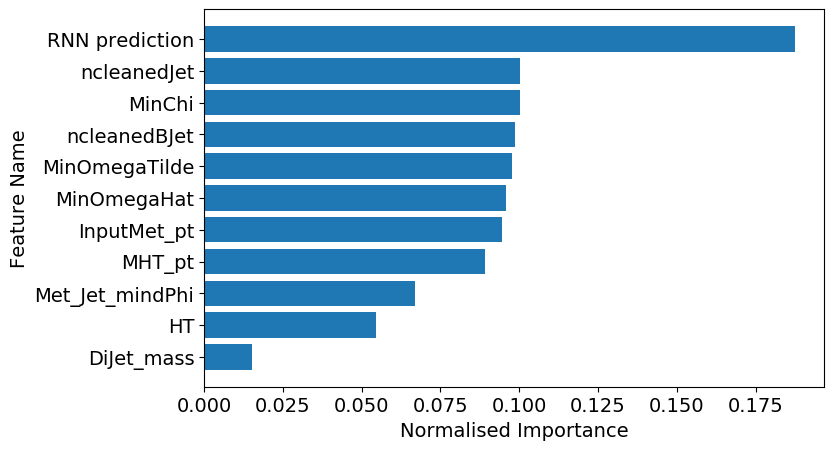

In [13]:
feature_names[2] = 'Met_Jet_mindPhi'

# plot it as a horizontal bar
plt.figure(dpi=100, figsize=(8, 5))
# Plotting horizontal bar chart
plt.barh(feature_names, importance_scores)
plt.xlabel('Normalised Importance', fontsize=14)
plt.ylabel('Feature Name', fontsize=14)

#ax.set_yticks(feature_names, ticks)
plt.tick_params(axis='both', labelsize=14)
plt.savefig('binary_permutation.png', dpi=300, bbox_inches='tight')

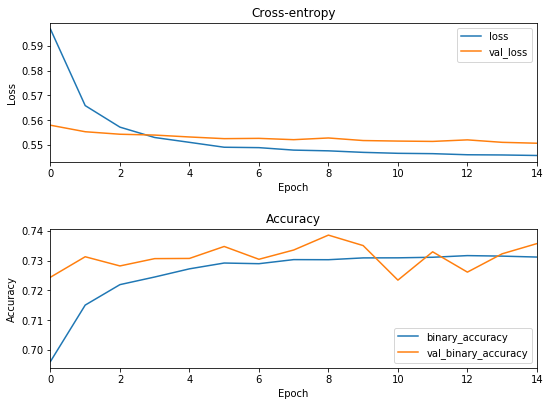

Best Validation Loss: 0.5506
Best Validation Accuracy: 0.7386


In [13]:
history_df = pd.DataFrame(history.history)
fig, axes = plt.subplots(nrows=2, figsize=(8, 6))
history_df.loc[:, ['loss', 'val_loss']].plot(ax=axes[0], title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(ax=axes[1], title="Accuracy")

# Set x-axis label
axes[-1].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_xlabel('Epoch')
axes[-1].set_ylabel("Accuracy")

# Set layout and padding
fig.tight_layout(pad=2.0)
plt.show()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))


In [14]:
history_df = pd.DataFrame(history.history)


# # Save the DataFrame to an HDF5 file
with h5py.File('combined_run8_training_data.h5', 'w') as hf:
    hf.create_dataset('df', data=history_df)

# with h5py.File('MLP_rnn_run1_training_data.h5', 'r') as hf:
#     history_df = pd.DataFrame(hf['df'][:])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation loss: 0.8160530936672731
Validation accuracy: 0.54573715
704876/1 - 28s


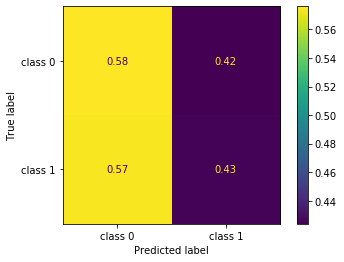

Total signal processes; 1.0
Total background processes; 1.0
299032
There is 142031 signal in the set
The model predicted 157001 more ones than in reality
405844
There is 562845 background in the set
The model predicted -157001 more ones than in reality


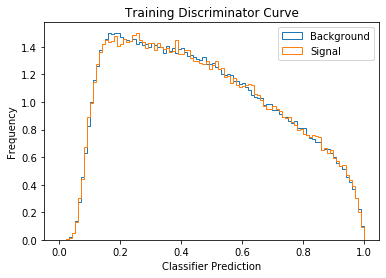

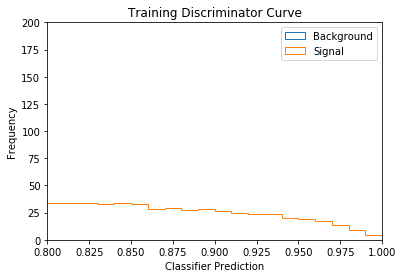

num_bg_events_training =  217397.73435500264
num_signal_events_training =  4395.567871302366


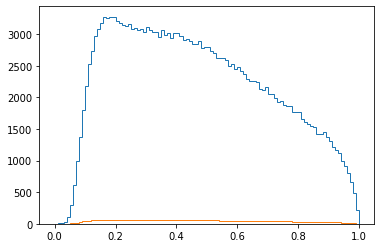

In [16]:
# evaluate the model on the training data, confusion matrix and discriminator curve

#gpu_available = tf.test.is_gpu_available()
#print(gpu_available)   # check still on the gpu

val_loss, val_acc = model.evaluate(X_train, y_train)    

print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

y_pred = model.predict(X_train, verbose = 2)
y_pred_round = np.round(y_pred)
#print(y_pred)

# compute the confusion matrix

cm = confusion_matrix(y_train, y_pred_round, normalize = 'true')   #, normalize = 'true')  #,'true' ‘pred’, ‘all’},)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['class 0', 'class 1']) # other env

disp.plot()
plt.show()

print('Total signal processes;', cm[1,0]+cm[1,1])
print('Total background processes;', cm[0,0]+cm[0,1])

# Check if order of y_valid is the same order as y_pred
# expect to be the ssame order if accuracy is same as validation accuracy above.

# list of true outcomes
y_train_list = list(y_train)

# list of rounded predictions 
y_pred_round_list = list(y_pred_round)

data_test = {'True_Val': y_train_list, 'Predicted': list(y_pred), 'Round Prediction': y_pred_round_list}
df_test = pd.DataFrame(data_test)

# Easiest to reorder df, so all 0 (background) are first and then 1's (signal)

#Verified, works
df_test = df_test.sort_values(by='True_Val')
df_test

# Convert arrays to scalars
df_test['Round Prediction'] = df_test['Round Prediction'].apply(lambda x: x[0])
        
pred_one = df_test['Round Prediction'].value_counts()[1.0]
ones_in_set = df_test['True_Val'].value_counts()[1]

# Print the result
print(pred_one)
print('There is', ones_in_set, 'signal in the set')
print('The model predicted',pred_one-ones_in_set ,'more ones than in reality')


pred_zeros = df_test['Round Prediction'].value_counts()[0.0]
zeros_in_set = df_test['True_Val'].value_counts()[0]

# Print the result
print(pred_zeros)
print('There is', zeros_in_set, 'background in the set')   #agrees w/ confusion matrix
print('The model predicted', pred_zeros-zeros_in_set,'more ones than in reality')


#Split df into signal and bg

df_bg = df_test[df_test['True_Val'] == 0]
df_signal = df_test[df_test['True_Val'] == 1]

# Make discriminator curves, Histogram

# manipluate data so can be used for Histograms
lst_bg_predicted = []
for i in df_bg['Predicted']:
    lst_bg_predicted.append(i)

lst_of_values_bg_pred_train = [arr.item() for arr in lst_bg_predicted]

lst_signal_predicted = []
for i in df_signal['Predicted']:
    lst_signal_predicted.append(i)

lst_of_values_signal_pred_train = [arr.item() for arr in lst_signal_predicted]

binwidth = 0.01
bins=np.arange(0, 1 + binwidth, binwidth)
    

#Unweighted, normalised
plt.hist(x= lst_of_values_bg_pred_train, bins=bins, density = True, histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred_train, bins=bins, density = True, histtype = 'step', label = 'Signal')
plt.title('Training Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#Weighted to xs_weights x 300000, need to be toproportion of full dataset too
#normalised

plt.hist(x= lst_of_values_bg_pred_train, bins=bins,  weights = df_weights[:len(lst_of_values_bg_pred_train),1]*3e5*1/0.8,
         histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred_train, bins=bins, weights = df_weights[:len(lst_of_values_signal_pred_train),3]*3e5*1/0.8,
         histtype = 'step', label = 'Signal')
plt.title('Training Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.xlim(0.8,1)    #zoom in on 0.9 to 1 region
plt.ylim(0,200)    # need to zoom in
plt.legend()
plt.show()


#Calculate number of events

n_bg, bins_bg, patches_bg = plt.hist(x= lst_of_values_bg_pred_train, bins=bins,  weights = df_weights[:len(lst_of_values_bg_pred_train),1]*3e5*1/0.8,
         histtype = 'step', label = 'Background')
n_signal, bins_signal, patches_signal = plt.hist(x= lst_of_values_signal_pred_train, bins=bins, weights = df_weights[:len(lst_of_values_signal_pred_train),3]*3e5*1/0.8,
         histtype = 'step', label = 'Signal')

# calculate the number of events
num_bg_events = np.sum(n_bg)
num_signal_events = np.sum(n_signal)

print('num_bg_events_training = ', num_bg_events)
print('num_signal_events_training = ', num_signal_events)

#start dropping bins for signifucance part, calc Z and plot, should get curve that peaks

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation loss: 0.5354826114617687
Validation accuracy: 0.7357394


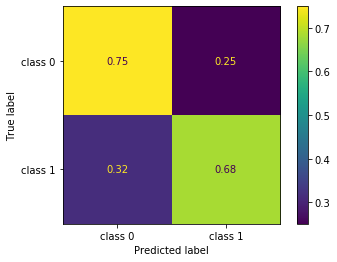

Total signal processes; 1.0
Total background processes; 1.0


In [17]:
# evaluate the model on the validation data

val_loss, val_acc = model.evaluate(X_valid, y_valid)   
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

y_pred = model.predict(X_valid)
y_pred_round = np.round(y_pred)

# compute the confusion matrix
cm = confusion_matrix(y_valid, y_pred_round, normalize = 'true')    #,'true' ‘pred’, ‘all’},)#
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['class 0', 'class 1']) # other env
#disp = ConfusionMatrixDisplay(confusion_matrix=cm)   
disp.plot()
plt.show()

print('Total signal processes;', cm[1,0]+cm[1,1])
print('Total background processes;', cm[0,0]+cm[0,1])

In [18]:
# Check if order of y_valid is the same order as y_pred
# expect to be the ssame order if accuracy is same as validation accuracy above.

# list of true outcomes
y_valid_list = list(y_valid)

# list of rounded predictions 
y_pred_round_list = list(y_pred_round)

# list of whether these are same    
z=[]
for i in range(len(y_valid_list)):
    if y_valid_list[i]==y_pred_round_list[i]:
        z.append(1)
    else:
        z.append(0)
        
print(sum(z)/len(z))

# Set a tolerance
tol = 0.0001
print(val_acc - tol < sum(z)/len(z) < val_acc + tol)

# If true, suggests are in same order 

0.735739416638293
True


In [19]:
data = {'True_Val': y_valid_list, 'Predicted': list(y_pred), 'Round Prediction': y_pred_round_list}
df = pd.DataFrame(data)

# Easiest to reorder df, so all 0 (background) are first and then 1's (signal)

#Verified, works
df = df.sort_values(by='True_Val')

# Convert arrays to scalars
df['Round Prediction'] = df['Round Prediction'].apply(lambda x: x[0])

In [20]:
# Check that they maintained order in the df:

lst=[]
for i in range(len(df)):
    if df['True_Val'][i] == df['Round Prediction'][i]:
        lst.append(1)
    else:
        (lst.append(0))
print(sum(lst)/len(lst))

# Set a tolerance
tol = 0.0001
print(val_acc - tol < sum(lst)/len(lst) < val_acc + tol)

# If true, suggests are in same order 

0.735739416638293
True


In [21]:
pred_one = df['Round Prediction'].value_counts()[1.0]
ones_in_set = df['True_Val'].value_counts()[1]

# Print the result
print(pred_one)
print('There is', ones_in_set, 'signal in the set')
print('The model predicted',pred_one-ones_in_set ,'more ones than in reality')


pred_zeros = df['Round Prediction'].value_counts()[0.0]
zeros_in_set = df['True_Val'].value_counts()[0]

# Print the result
print(pred_zeros)
print('There is', zeros_in_set, 'background in the set')   #agrees w/ confusion matrix
print('The model predicted', pred_zeros-zeros_in_set,'more ones than in reality')


59775
There is 35827 signal in the set
The model predicted 23948 more ones than in reality
116445
There is 140393 background in the set
The model predicted -23948 more ones than in reality


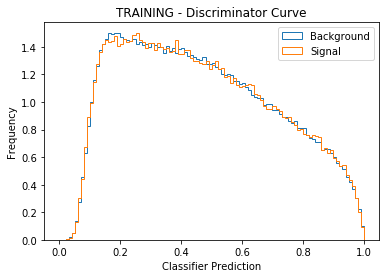

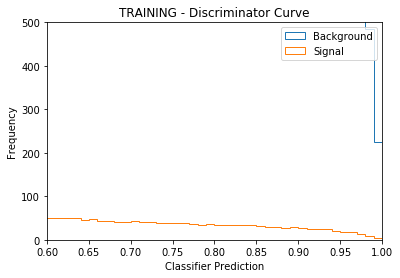

In [22]:
# Training Discriminator curves

#Unweighted, normalised
plt.hist(x= lst_of_values_bg_pred_train, bins=bins, density = True, histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred_train, bins=bins, density = True, histtype = 'step', label = 'Signal')
plt.title('TRAINING - Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#Weighted to xs_weights x 300000, need to be toproportion of full dataset too
#normalised


plt.hist(x= lst_of_values_bg_pred_train, bins=bins,  weights = df_weights[:len(lst_of_values_bg_pred_train),1]*3e5*1/0.8,
         histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred_train, bins=bins, weights = df_weights[:len(lst_of_values_signal_pred_train),3]*3e5*1/0.8,
         histtype = 'step', label = 'Signal')
plt.title('TRAINING - Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.xlim(0.6,1)    #zoom in on 0.9 to 1 region
plt.ylim(0,500)    # need to zoom in
plt.legend()
plt.show()


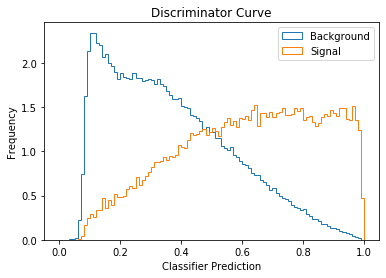

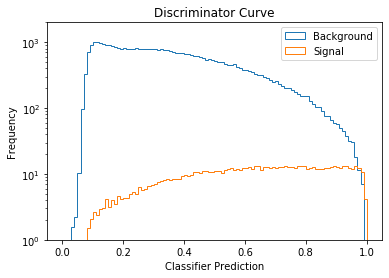

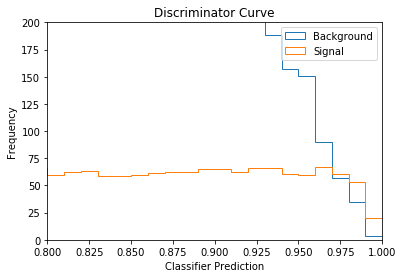

In [23]:
#Split df into signal and bg

df_bg = df[df['True_Val'] == 0]
df_signal = df[df['True_Val'] == 1]

# Make Validation discriminator curves, Histogram

# manipluate data so can be used for Histograms
lst_bg_predicted = []
for i in df_bg['Predicted']:
    lst_bg_predicted.append(i)

lst_of_values_bg_pred = [arr.item() for arr in lst_bg_predicted]

lst_signal_predicted = []
for i in df_signal['Predicted']:
    lst_signal_predicted.append(i)

lst_of_values_signal_pred = [arr.item() for arr in lst_signal_predicted]

binwidth = 0.01
bins=np.arange(0, 1 + binwidth, binwidth)

#Unweighted, normalised
plt.hist(x= lst_of_values_bg_pred, bins=bins, density = True, histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred, bins=bins, density = True, histtype = 'step', label = 'Signal')
plt.title('Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#Weighted to xs_weights x 300000, need to be toproportion of full dataset too
#normalised
plt.hist(x= lst_of_values_bg_pred, bins=bins,  weights = df_weights[:len(lst_of_values_bg_pred),1]*3e5,
         histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred, bins=bins, weights = df_weights[:len(lst_of_values_signal_pred),3]*3e5,
         histtype = 'step', label = 'Signal')
plt.title('Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
#plt.xlim(0.9,1)    #zoom in on 0.9 to 1 region
plt.ylim(1,2000)    # need to zoom in
plt.yscale('log')
plt.legend()
plt.show()
    
plt.hist(x= lst_of_values_bg_pred, bins=bins,  weights = df_weights[:len(lst_of_values_bg_pred),1]*3e5*1/0.2,
         histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred, bins=bins, weights = df_weights[:len(lst_of_values_signal_pred),3]*3e5*1/0.2,
         histtype = 'step', label = 'Signal')
plt.title('Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.xlim(0.8,1)    #zoom in on 0.9 to 1 region
plt.ylim(0,200)    # need to zoom in
plt.legend()
plt.show()


#start dropping bins for signifucance part, calc Z and plot, should get curve that peaks

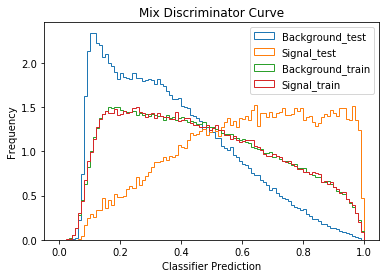

In [24]:
# Test and Training overlayed

#Unweighted, normalised
plt.hist(x= lst_of_values_bg_pred, bins=bins, density = True, histtype = 'step', label = 'Background_test')
plt.hist(x= lst_of_values_signal_pred, bins=bins, density = True, histtype = 'step', label = 'Signal_test')
plt.title('Test - Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.legend()


#Unweighted, normalised
plt.hist(x= lst_of_values_bg_pred_train, bins=bins, density = True, histtype = 'step', label = 'Background_train')
plt.hist(x= lst_of_values_signal_pred_train, bins=bins, density = True, histtype = 'step', label = 'Signal_train')
plt.title('Mix Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.legend()
plt.show()

num_bg_events_validation =  216880.34381079674
num_signal_events_validation =  4430.54150390625


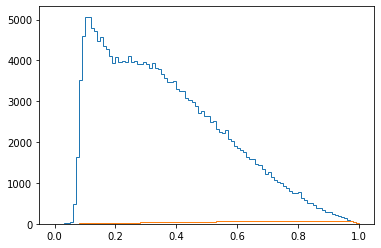

In [25]:
#Calculate number of events

n_bg, bins_bg, patches_bg = plt.hist(x= lst_of_values_bg_pred, bins=bins, weights = df_weights[:len(lst_of_values_bg_pred),1]*3e5*1/0.2,
         histtype = 'step', label = 'Background')
n_signal, bins_signal, patches_signal = plt.hist(x= lst_of_values_signal_pred, bins=bins, weights = df_weights[:len(lst_of_values_signal_pred),3]*3e5*1/0.2,
         histtype = 'step', label = 'Signal')

# calculate the number of events
num_bg_events = np.sum(n_bg)
num_signal_events = np.sum(n_signal)

print('num_bg_events_validation = ', num_bg_events)
print('num_signal_events_validation = ', num_signal_events)

In [25]:
df['True_Val'] = df['True_Val'].astype(float)
df['Predicted'] = df['Predicted'].astype(float)
df['Round Prediction'] = df['Round Prediction'].astype(float)


# Save the DataFrame to an HDF5 file
with h5py.File('combined_run8_ROC_data.h5', 'w') as hf:
    hf.create_dataset('df', data=df)
    
# with h5py.File('run1_ROC_data.h5', 'r') as hf:
#     df = pd.DataFrame(hf['df'][:])


In [26]:
# #plot ROC curves

# y_true = df['True_Val']
# y_score = df['Predicted']

# # calculate the false positive rate and true positive rate
# fpr, tpr, thresholds = roc_curve(y_true, y_score)

# # calculate the area under the ROC curve
# roc_auc = auc(fpr, tpr)

# # plot the ROC curve
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")
# plt.show()

# print(roc_auc)  #79%

# print(len(thresholds))



In [27]:
# data_roc = {'thresholds': thresholds, 'tpr': tpr, 'fpr': fpr, 'tpr/sqrt(fpr)':tpr/np.sqrt(fpr)}
# df_roc = pd.DataFrame(data_roc)
# #df_roc
# df_roc.head(20)
# plt.plot(df_roc['thresholds'][3:], df_roc['tpr/sqrt(fpr)'][3:])
# plt.show()
# max(df_roc['tpr/sqrt(fpr)'][3:])

In [28]:
# # Plot precision recall curve
# from sklearn.metrics import average_precision_score

# y_true = df['True_Val']
# y_score = df['Predicted']

# # calculate the precision-recall curve
# precision, recall, _ = precision_recall_curve(y_true, y_score)

# # plot the precision-recall curve
# plt.step(recall, precision, color='b', alpha=0.2, where='post')
# plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])
# plt.title('Precision-Recall Curve')
# plt.show()

# AUC = average_precision_score(y_true, y_score)   #0.793, pretty similar to roc AUC
# print(AUC)

In [29]:
# df['True_Val']
# x = df['Predicted']
# print(x)

# Significance

$$ Z = \frac{s}{\sqrt(B+\sigma_s^{2})}  $$

s = number of signal

B = number of background

$\sigma_s$ = statistical uncertainty (~10% of B)

216880.34381079674
4430.54150390625


/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


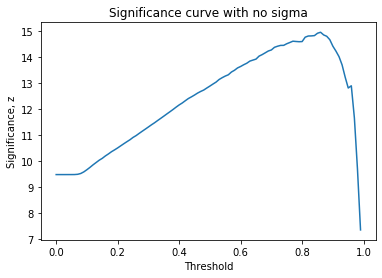

0.86
86
14.962815370155152

If cut at a threshold of 0.86 have
833.201904296875 singal events
2835.078125 background events


/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less


In [26]:
num_bg_events = np.sum(n_bg)
num_signal_events = np.sum(n_signal)

print(num_bg_events)
print(num_signal_events)

z_0 = np.empty(len(bins_bg))
for i in range(len(bins_bg)):
    b = np.sum(n_bg[i:])
    s = np.sum(n_signal[i:])
    z_i = np.sqrt(2*((s+b)*np.log(1+(s/b))-s))  
    z_0[i] = z_i

x = np.linspace(0,1,len(z_0))
plt.plot(bins_bg,z_0[:])
plt.xlabel('Threshold')
plt.ylabel('Significance, z')
plt.title('Significance curve with no sigma')
plt.show()


mask_0 = z_0 < 1e10     #just so doesnt include infs
index_of_max_0 = np.argmax(z_0[mask_0])
max_value_0 = np.amax(z_0[mask_0])


#index_of_max = np.nanargmax(z[:])
#max_value = np.nanmax(z[:])     # 1 point before last, should probs generalise so that can deal w inf etc 
max_bin_0 = bins_bg[index_of_max_0]
print(max_bin_0)
print(index_of_max_0)
print(max_value_0)

# significance = sigmna, 6.5 signma, 5 sigma

num_bg_threshold_0 = np.sum(n_bg[index_of_max_0:])
num_signal_threshold_0 = np.sum(n_signal[index_of_max_0:])

print()
print('If cut at a threshold of', index_of_max_0/100, 'have')
print(num_signal_threshold_0, 'singal events')
print(num_bg_threshold_0, 'background events')

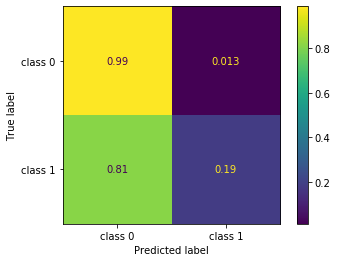

Total signal processes; 1.0
Total background processes; 1.0


In [27]:
# Confusion matricies with new threshold at max significance

# calculates prediction values
#y_pred = model.predict(X_valid) 

significance_threshold_0 = max_bin_0
y_pred_threshold_0 = np.where(y_pred >= significance_threshold_0, 1, 0)

# compute the confusion matrix
cm = confusion_matrix(y_valid, y_pred_threshold_0, normalize = 'true')    #,'true' ‘pred’, ‘all’},)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm)   
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['class 0', 'class 1']) # other env
disp.plot()
plt.show()

print('Total signal processes;', cm[1,0]+cm[1,1])
print('Total background processes;', cm[0,0]+cm[0,1])

216880.34381079674
4430.54150390625


/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


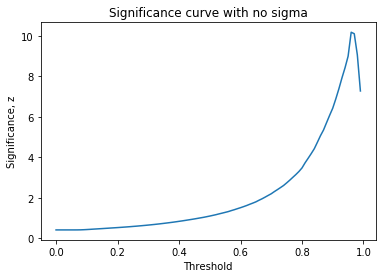

0.96
96
10.18772323280315

If cut at a threshold of 0.96 have
20.168408203125 singal events
185.53125 background events


/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in less


In [38]:
num_bg_events = np.sum(n_bg)
num_signal_events = np.sum(n_signal)

print(num_bg_events)
print(num_signal_events)

z_5 = np.empty(len(bins_bg))
for i in range(len(bins_bg)):
    b = np.sum(n_bg[i:])
    s = np.sum(n_signal[i:])

    sigma = 0.05*b  
    part1 = (s+b)*np.log(((s+b)*(b+sigma**2))/(b**2+((s+b)*sigma**2)))
    part2 = (b**2/sigma**2)*np.log(1+((sigma**2*s)/(b*(b+sigma**2))))
    
    z_5[i] = (2*(part1-part2))**(1/2)

x = np.linspace(0,1,len(z_5))
plt.plot(bins_bg,z_5[:])
plt.xlabel('Threshold')
plt.ylabel('Significance, z')
plt.title('Significance curve with no sigma')
plt.show()


mask_5 = z_5 < 1e10     #just so doesnt include infs
index_of_max_5 = np.argmax(z_5[mask_5])
max_value_5 = np.amax(z_5[mask_5])


#index_of_max = np.nanargmax(z[:])
#max_value = np.nanmax(z[:])     # 1 point before last, should probs generalise so that can deal w inf etc 
max_bin_5 = bins_bg[index_of_max_5]
print(max_bin_5)
print(index_of_max_5)
print(max_value_5)

# significance = sigmna, 6.5 signma, 5 sigma

num_bg_threshold_5 = np.sum(n_bg[index_of_max_5:])
num_signal_threshold_5 = np.sum(n_signal[index_of_max_5:])/10

print()
print('If cut at a threshold of', index_of_max_5/100, 'have')
print(num_signal_threshold_5, 'singal events')
print(num_bg_threshold_5, 'background events')

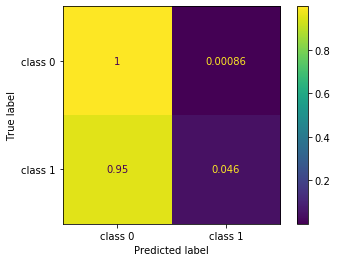

Total signal processes; 1.0
Total background processes; 1.0


In [34]:
# Confusion matricies with new threshold at max significance

# calculates prediction values
#y_pred = model.predict(X_valid) 

significance_threshold_5 = max_bin_5
y_pred_threshold_5 = np.where(y_pred >= significance_threshold_5, 1, 0)

# compute the confusion matrix
cm = confusion_matrix(y_valid, y_pred_threshold_5, normalize = 'true')    #,'true' ‘pred’, ‘all’},)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm)   
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['class 0', 'class 1']) # other env
disp.plot()
plt.show()

print('Total signal processes;', cm[1,0]+cm[1,1])
print('Total background processes;', cm[0,0]+cm[0,1])

216880.34381079674
4430.54150390625


/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


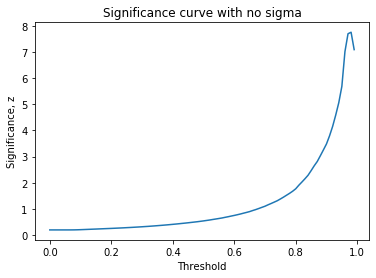

0.98
98
7.749755121340382

If cut at a threshold of 0.98 have
74.05078125 singal events
38.0625 background events


/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in less


In [30]:
num_bg_events = np.sum(n_bg)
num_signal_events = np.sum(n_signal)

print(num_bg_events)
print(num_signal_events)

z_10 = np.empty(len(bins_bg))
for i in range(len(bins_bg)):
    b = np.sum(n_bg[i:])
    s = np.sum(n_signal[i:])

    sigma = 0.1*b  
    part1 = (s+b)*np.log(((s+b)*(b+sigma**2))/(b**2+((s+b)*sigma**2)))
    part2 = (b**2/sigma**2)*np.log(1+((sigma**2*s)/(b*(b+sigma**2))))
    
    z_10[i] = (2*(part1-part2))**(1/2)

x = np.linspace(0,1,len(z_10))
plt.plot(bins_bg,z_10[:])
plt.xlabel('Threshold')
plt.ylabel('Significance, z')
plt.title('Significance curve with no sigma')
plt.show()


mask_10 = z_10 < 1e10     #just so doesnt include infs
index_of_max_10 = np.argmax(z_10[mask_10])
max_value_10 = np.amax(z_10[mask_10])


#index_of_max = np.nanargmax(z[:])
#max_value = np.nanmax(z[:])     # 1 point before last, should probs generalise so that can deal w inf etc 
max_bin_10 = bins_bg[index_of_max_10]
print(max_bin_10)
print(index_of_max_10)
print(max_value_10)

# significance = sigmna, 6.5 signma, 5 sigma

num_bg_threshold_10 = np.sum(n_bg[index_of_max_10:])
num_signal_threshold_10 = np.sum(n_signal[index_of_max_10:])

print()
print('If cut at a threshold of', index_of_max_10/100, 'have')
print(num_signal_threshold_10, 'singal events')
print(num_bg_threshold_10, 'background events')

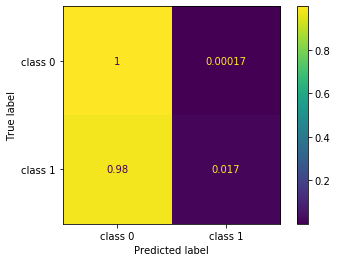

Total signal processes; 1.0
Total background processes; 1.0


In [31]:
# Confusion matricies with new threshold at max significance

# calculates prediction values
#y_pred = model.predict(X_valid) 

significance_threshold_10 = max_bin_10
y_pred_threshold_10 = np.where(y_pred >= significance_threshold_10, 1, 0)

# compute the confusion matrix
cm = confusion_matrix(y_valid, y_pred_threshold_10, normalize = 'true')    #,'true' ‘pred’, ‘all’},)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm)   
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['class 0', 'class 1']) # other env
disp.plot()
plt.show()

print('Total signal processes;', cm[1,0]+cm[1,1])
print('Total background processes;', cm[0,0]+cm[0,1])

In [1]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(16,8))


# plot the first confusion matrix
cm = confusion_matrix(y_valid, y_pred_round, normalize = 'true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Background', 'Signal'])
disp.plot(ax=axs[0])
axs[0].set_title('Threshold 0.5')



# plot the second confusion matrix
cm_5 = confusion_matrix(y_valid, y_pred_threshold_5, normalize = 'true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_5, display_labels=['Background', 'Signal'])
disp.plot(ax=axs[1])
axs[1].set_title(f'Threshold {index_of_max_5/100}')

# Adjust the spacing between subplots
fig.subplots_adjust(hspace=0.35)

plt.show()


NameError: name 'plt' is not defined

In [29]:
raw_sig_curve_data = {'syst_uncertainty (0%)': z_0, 
                      'syst_uncertainty (5%)': z_5, 
                      'syst_uncertainty (10%)': z_10, 
                     }
raw_sig_df = pd.DataFrame(raw_sig_curve_data)


# Save the DataFrame to an HDF5 file
with h5py.File('combined_raw_sig_data_run8.h5', 'w') as hf:
    hf.create_dataset('df', data=raw_sig_df)

In [36]:
significances = np.array((max_value_0, max_value_5, max_value_10))
syst_uncertainty = np.array((0, 0.05, 0.1))
discriminators = np.array((index_of_max_0/100, index_of_max_5/100, index_of_max_10/100))
num_bg_threshold = np.array((num_bg_threshold_0, num_bg_threshold_5, num_bg_threshold_10))
num_signal_threshold = np.array((num_signal_threshold_0,num_signal_threshold_5,num_signal_threshold_10))

In [37]:
sig_curve_data = {'syst_uncertainty (%)': syst_uncertainty, 'Significances': significances, 'Threshold': discriminators, 'no_bg': num_bg_threshold, 'no_signal':num_signal_threshold}
sig_df = pd.DataFrame(sig_curve_data)


# Save the DataFrame to an HDF5 file
with h5py.File('combined_sig_data_run8.h5', 'w') as hf:
    hf.create_dataset('df', data=sig_df)
    
# with h5py.File('run1_ROC_data.h5', 'r') as hf:
#     df = pd.DataFrame(hf['df'][:])

# can make confusion matricies with things I have saved

In [38]:
sig_df

,syst_uncertainty (%),Significances,Threshold,no_bg,no_signal
0,0.00,14.962815,0.86,2835.078125,833.201904
1,0.05,10.187723,0.96,185.531250,201.684082
2,0.10,7.749755,0.98,38.062500,74.050781


In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(6, 8))

# Plot 1- HT
bins = np.linspace(0,4000,100)
HT_bg =  df_total['HT'][:-177858]  
HT_signal = df_total['HT'][-177858:] 
axs[0].hist(x=HT_bg, bins=bins, weights = weights[:-177858] * 300000 , histtype='step', label='Background')
axs[0].hist(x = HT_signal, bins=bins, weights = weights[-177858:] * 300000, histtype='step', label='Signal')
#axs[0].set_title('HT')
axs[0].set_xlim(0,3000)
axs[0].set_yscale('log')
axs[0].set_ylabel('Number of events weighted to $300\,fb^{-1}$')
axs[0].set_xlabel('Hadronic Transverse Momentum, HT (GeV)')
axs[0].legend()


# Plot 2 - DiJet_mass
bins = np.linspace(0,4000,30)
DiJet_mass_bg =  df_total['DiJet_mass'][:-177858]  
DiJet_mass_signal = df_total['DiJet_mass'][-177858:] 
axs[1].hist(x=DiJet_mass_bg, bins=bins, weights = weights[:-177858] * 300000 , histtype='step', label='Background')
axs[1].hist(x = DiJet_mass_signal, bins=bins,weights = weights[-177858:] * 300000 , histtype='step', label='Signal')
#axs[1].set_title('DiJet_mass')
axs[1].set_xlim(-50,3000)
axs[1].set_ylabel('Number of events weighted to $300\,fb^{-1}$')
axs[1].set_yscale('log')
axs[1].set_xlabel('DiJet Mass (GeV)')
axs[1].legend()



plt.subplots_adjust(hspace = 0.4)
plt.savefig('Hists1.png', dpi=300, bbox_inches='tight')
